<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/ai4eo_logos.jpg' align='right' width='100%'/>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT <br>
**Adapted from worklows developed under the 2022 <a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/" target="_blank">AI4EO MOOC</a>**

<div class="alert alert-block alert-success">
<h3>Ocean colour applications</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- asdf

</div>
<hr>

# Using machine learning for retrieval of water quality indicators: an auto-associative neural network approach

<i>by Ben Loveday (Innoflair/EUMETSAT) and Hayley Evers-King (EUMETSAT), using tools developed by Brockmann Consult</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/631902470?h=0aa88847b3" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

*Note: This notebook has iterated since the making of this video, so you may notice a couple of small changes. This is mostly around data access.*

<hr>

## Introduction

<hr>

*Why are we doing this?*

In the previous example we showed you how to use `naive bayesian classifiers` to partition waters into those that are more representative of the open ocean, and those that are more complex. However, this approach merely 'splits' the ocean domain, giving some guidance about what algorithms may be valid in given regions. It does not actually retrieve any ocean parameters, e.g. chlorophyll.

In this example, we build on this basis and introduce an `auto-associative neural network` approach that can be applied anywhere in the ocean. This processor, the result of significant research across the ocean colour community, products estimates of many in water properties, including chlorophyll and sediment concentrations.

<hr>

*What will this workflow show you?* 

The workflow also shows an example of how and where you can use the [C2RCC](https://www.brockmann-consult.de/portfolio/water-quality-from-space/) `auto-associative neural network` processor to retrieve in water parameters in complex waters, and what advantages it presents.

## Machine-Learning Algorithms

In this workflow you will learn about applying machine-learning related methods to ocean colour data.

This example uses [auto-associate neural networks (AANN)](https://www.geeksforgeeks.org/auto-associative-neural-networks/), which include multiple-layers with weighted connections. The example used is based upon a number of AANN's that are connected to form an end-to-end processing architecture (see figure 1). This processor can be found in the freely available [ESA SNAP software](http://step.esa.int/main/download/snap-download/), which also contains the coefficients for the trained neural network.

## Data

This workflow uses the following data:
* An [OLCI full resolution Level-2](https://www-cdn.eumetsat.int/files/2021-03/Sentinel-3%20OLCI%20Marine%20User%20Handbook.pdf) scene for the North Sea 16.04.2021

The standard Level-2 product contains some output from the C2RCC AANN processor, including the chlorophyll and sediment concentrations.

## Further resources

*Any additional links to Github repositories, papers, case studies etc.*

* [OLCI Marine User Handbook](https://www.eumetsat.int/media/45743)
* [Brockmann et al., 2016 - Evolution of the C2RCC neural network for Sentinel 2 and 3 or the retrieval of ocean colour products in normal and extreme optically complex waters.](http://step.esa.int/docs/extra/Evolution%20of%20the%20C2RCC_LPS16.pdf)
* [Doerffer and Schiller, 2007 - The MERIS Case 2 water algorithm.](https://www.tandfonline.com/doi/abs/10.1080/01431160600821127) 

<hr>

## Notebook outline
* [1 - Example: The Case-2 Regional Coast Colour Algorithm (C2RCC)](#example2_c2rcc)
* [2 - Conclusions](#conclusions)

<hr>

#### Import libraries

In [2]:
import os # a library that gives us access to various command line tools to support pathing
import sys # a library that gives us access to various command line tools to support pathing
import cartopy.crs as ccrs # a library that gives us access to cartopy's mapping capability
import cartopy.feature as cfeature # a library that extends cartopy to include features such as land masks
import matplotlib # the basic python plotting library
from matplotlib import gridspec # a library that gives us better control over plot spacing
import matplotlib.pyplot as plt # the basic Python plotting library figure tools
import numpy as np # Python's array manipulation library 
import warnings # a library to manage warnings
import xarray as xr # a library to extend array management and add labelling
import requests # library for fetching data via HTTP
import zipfile # a library that helps us work with zip files
import io # a library that helps us translate data between fundamental formats
warnings.filterwarnings('ignore')
sys.path.append(os.path.dirname(os.getcwd()))

#### Defined functions

In [3]:
import common_functions as osf # an accompanying library of bespoke functions to support this notebook

#### Fetching example data

Lets fetch our example data. This can take a little time.

In [4]:
urls = ["https://wekeo-files.apps.mercator.dpi.wekeo.eu/s/JxK3FWjjNQbX2XM/download/Support_data.zip"]
for url in urls:
    if not os.path.exists(os.path.basename(url).split('.')[0]):
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(os.path.dirname(os.path.abspath(__file__)))

<hr>

## Example: The Case-2 Regional Coast Colour Algorithm (C2RCC)<a id='example2_c2rcc'></a>

As in the [previous example](./4Fa_Using_ML_for_water_type_identification.ipynb), we will begin with a little bit of preparation for our plotting. You do not need to alter anything here, but if you find that you are having memory problems on your local system you can increase the grid_factor parameter and/or reduce the size of your subset. You can also set these parameters to false if you want to try running with a full image!

In [5]:
# image reduction settings: resample the image every grid_factor points
run_reduce_image = True
grid_factor = 5

# subset image: cut a relevant section out of an image. subset_extents [lon1,lon2,lat1,lat2] describes the section.
run_subset_image = True
subset_extents = [-2.0, 12.0, 51.75, 59.25]

# image plotting settings: e.g. fontsize (fsz)
fsz = 10
plt.rc('font', size=fsz)
dpi = 150

# get our land mask from NaturalEarth
land_poly = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='k', facecolor=cfeature.COLORS['land'])

Below we define three boxes, over which we will compare some retrieved parameters.

In [6]:
# spectral_box_extents: Selects are area (or point) to extract spectra from
spectral_box_extents = [[10.0, 10.5, 57.75, 58.25], [3.5, 4.0, 53.25, 53.75],[7.75,8.25,54.25,54.75]]
spectral_plot_cols = ['#00FFFF','#FF6103', '#8A2BE2']

### Loading the example images

You will begin by setting a few parameters, such as `DATA_PATHS` that point to where you can find the example OLCI data. 

In [7]:
# set data paths and files names
DATA_PATHS = [os.path.join(os.getcwd(),'Support_data',
              'S3A_OL_2_WFR____20210416T095514_20210416T095814_20210417T203718_0179_070_350_1980_MAR_O_NT_003.SEN3')]

A principally similar approach to that used in our first example, has been used to develop an ocean colour data processor to provide estimates of ocean properties in complex coastal waters. The approach also includes the atmospheric correction process, which is also challenging in these regions. 

The Case-2 regional processor from the CoastColour project (C2RCC) was developed using a much more comprehensive data set that consists of in situ measurements of reflectance and atmosphere and ocean parameters (including inherent optical properties, chlorophyll-a, coloured dissolved organic matter, and total suspended matter concentrations, collected from all over the world), as well as a modelled data set of over 5 million spectra generated from a wide range of variability in the aforementioned parameters. 

The approach uses a number of trained auto-associative neural nets to conduct the atmospheric correction and then derive the water reflectance, inherent optical properties (IOPs), the diffuse attenuation coefficient (K$_{d}$ - indicative of water transparency), chlorophyll-a and total suspected matter (TSM) concentrations. See Figure 5 below for further details on the AANNs within the processor.

The C2RCC is part of the operational processing chain for Sentinel-3 OLCI data, and you can find some of the outputs (the IOP, Chlorophyll-a and TSM) in the level-2 OLCI products. More information about this processor can be found in the [OLCI marine user handbook](https://www.eumetsat.int/media/45743), [Doerffer and Schiller (2007)](https://www.mdpi.com/2072-4292/10/5/786/ht) and [Brockmann et al., (2016)](https://www.brockmann-consult.de/wp-content/uploads/2017/11/sco1_12brockmann.pdf).

You can also run this processor yourself using the Sentinel Application Platform (SNAP), on SeaWIFS, MODIS, MERIS, VIIRS, Landsat 8, Sentinel-2 MSI, and Sentinel-3 OLCI data. You can download a copy of SNAP for your own computer [here](https://step.esa.int/main/download/snap-download/). It can also be used on the WEkEO virtual machines. 

<table><tr>
<td> <img src="../../../img/C2RCC_NN_1.png" alt="Drawing" style="45%"/> </td>
<td> <img src="../../../img/C2RCC_NN_2.png" alt="Drawing" style="45%"/> </td>
</tr></table>

<p style="text-align: center;">Figure 1: A schematic of the C2RCC processor.</p>

The C2RCC processor can be found in the SNAP software graphical user interface under the Optical >> Thematic Water Processors menus (see below). The processor can also be run from the command line as part of the Graph Processing Tool (GPT) functionality offered through SNAP. Support on use of the processor can be found through the [STEP forum](https://forum.step.esa.int/). 

<img src='../../../img/SNAP_GUI_C2RCC.png' align='centre' width='100%'></img>

<p style="text-align: center;">Figure 2: Implementing the C2RCC processor in SNAP. Your input product should be a Level-1B scene.</p>

### Comparing retrievals of water quality parameters

Lets have a look at what is obtained by applying the C2RCC processor to the level-1 OLCI data we looked at in section [Introduction to OLCI marine data](#OLCI_intro). This process takes us from level-1 to level-2 data and the C2RCC processor as implemented in SNAP will provide a very similar product in terms of format to the level-2 standard product. However in addition to the complex water products (CHL_NN, TSM_NN and IOP_NN) the full C2RCC processor output also provides the reflectance from OLCI corrected using the C2RCC atmospheric correction (see the [OLCI Marine User Handbook](https://www.eumetsat.int/media/45743) for a full overview of the OLCI processing chain and baseline atmospheric correction used for the standard product). 

In the code cells below you'll apply different sets of flags to the images, to align with the use of the standard product and C2RCC processor. You can see flag guidance in the [OLCI Marine User Handbook](https://www.eumetsat.int/media/45743).

First let's open the file containing our image coordinates and read in the latitude and longitude.

In [8]:
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'geo_coordinates.nc'))
rlat = ds1.latitude.data
rlon = ds1.longitude.data
ds1.close()

Next we will read in the standard chlorophyll-a product (dervied using the OC4ME algorithm).

In [9]:
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'chl_oc4me.nc'))
CHL_OC4ME = ds1.CHL_OC4ME.data
ds1.close()

Lastly we will read in our qualify flags (in the wqsf.nc file) and create a flag mask. The flag mask will be used to dispose of unreliable data; e.g. where it is cloudy of contaminated by sun glint.

In [10]:
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'wqsf.nc'))
# get all the flag names
flag_names = ds1.WQSF.flag_meanings.split(' ')
# get all the flag bit values
flag_vals = ds1.WQSF.flag_masks
# get the flag field itself
FLAGS = ds1.WQSF.data
ds1.close()

# OC4ME standard flags
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED',
                 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ADJAC',
                 'RWNEG_O2', 'RWNEG_O3', 'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8']
flag_mask_oc4 = osf.flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask_oc4 = flag_mask_oc4.astype(float)
flag_mask_oc4[flag_mask_oc4 == 0.0] = np.nan

In the next cell you do the same thing, but for two more variables produced by the C2RCC processor - `chlorophyll NN (neural network)` and `total suspended matter` (TSM). Again we will flag our data, but note that we use a slightly different flag-set for the NN variables.

In [11]:
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'chl_nn.nc'))       
CHL_NN = ds1.CHL_NN.data
ds1.close()

ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'tsm_nn.nc'))       
TSM_NN = ds1.TSM_NN.data
ds1.close()

# NN standard flags
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED',
                 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'OCNN_FAIL']
flag_mask_nn = osf.flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask_nn = flag_mask_nn.astype(float)
flag_mask_nn[flag_mask_nn == 0.0] = np.nan

Now that you have the flag masks, you can apply these to the data you want to plot.

In [12]:
# apply flag masks
CHL_OC4ME[np.isfinite(flag_mask_oc4)] = np.nan
CHL_NN[np.isfinite(flag_mask_nn)] = np.nan
TSM_NN[np.isfinite(flag_mask_nn)] = np.nan

Before we plots any data, lets also calculate the values of TSM and chlorophyll (both kinds) over each of our boxes.

In [13]:
TSM_mean = [] ; TSM_std = []
CHL_NN_mean = [] ; CHL_NN_std = []
CHL_OC4ME_mean = [] ; CHL_OC4ME_std = []
for spectral_box_extent in spectral_box_extents:
    print('Processing box...')
    I1, I2, J1, J2 = osf.get_coords(rlon, spectral_box_extent[0], spectral_box_extent[1],\
                                    rlat, spectral_box_extent[2], spectral_box_extent[3], False)
    TSM_mean.append(np.nanmean(10**TSM_NN[I1:I2,J1:J2]))
    TSM_std.append(np.nanstd(10**TSM_NN[I1:I2,J1:J2]))
    CHL_NN_mean.append(np.nanmean(10**CHL_NN[I1:I2,J1:J2]))
    CHL_NN_std.append(np.nanstd(10**CHL_NN[I1:I2,J1:J2]))
    CHL_OC4ME_mean.append(np.nanmean(10**CHL_OC4ME[I1:I2,J1:J2]))
    CHL_OC4ME_std.append(np.nanstd(10**CHL_OC4ME[I1:I2,J1:J2]))

Processing box...
Processing box...
Processing box...


The next section of code allows you to subset the images (as we did before), making plotting and interpretation more manageable. 

In [14]:
if run_subset_image:
    i1, i2, j1, j2 = osf.subset_image(rlat, rlon, subset_extents)
    lon = rlon[i1:i2,j1:j2]
    lat = rlat[i1:i2,j1:j2]
    CHL_OC4ME = CHL_OC4ME[i1:i2,j1:j2]
    CHL_NN = CHL_NN[i1:i2,j1:j2]
    TSM_NN = TSM_NN[i1:i2,j1:j2]

if run_reduce_image:
    CHL_OC4ME = osf.reduce_image(CHL_OC4ME, grid_factor=grid_factor)
    CHL_NN = osf.reduce_image(CHL_NN, grid_factor=grid_factor)
    TSM_NN = osf.reduce_image(TSM_NN, grid_factor=grid_factor)
    lon = osf.reduce_image(lon, grid_factor=grid_factor)
    lat = osf.reduce_image(lat, grid_factor=grid_factor)

Now we have prepared all of our data, we can finally you can plot it.

The code below is nearly identical to that used in the [Naive Bayesian example](../Bayesian_classification_of_water_types/Using_ML_for_water_type_identification.ipynb), just with the new variables from the C2RCC processor. First you can compare the standard chlorophyll-a concentration product from OLCI, estimated using the blue-green band ratio OC4ME, with the chlorophyll-a concentration derived from the C2RCC processor, informed by neural networks.

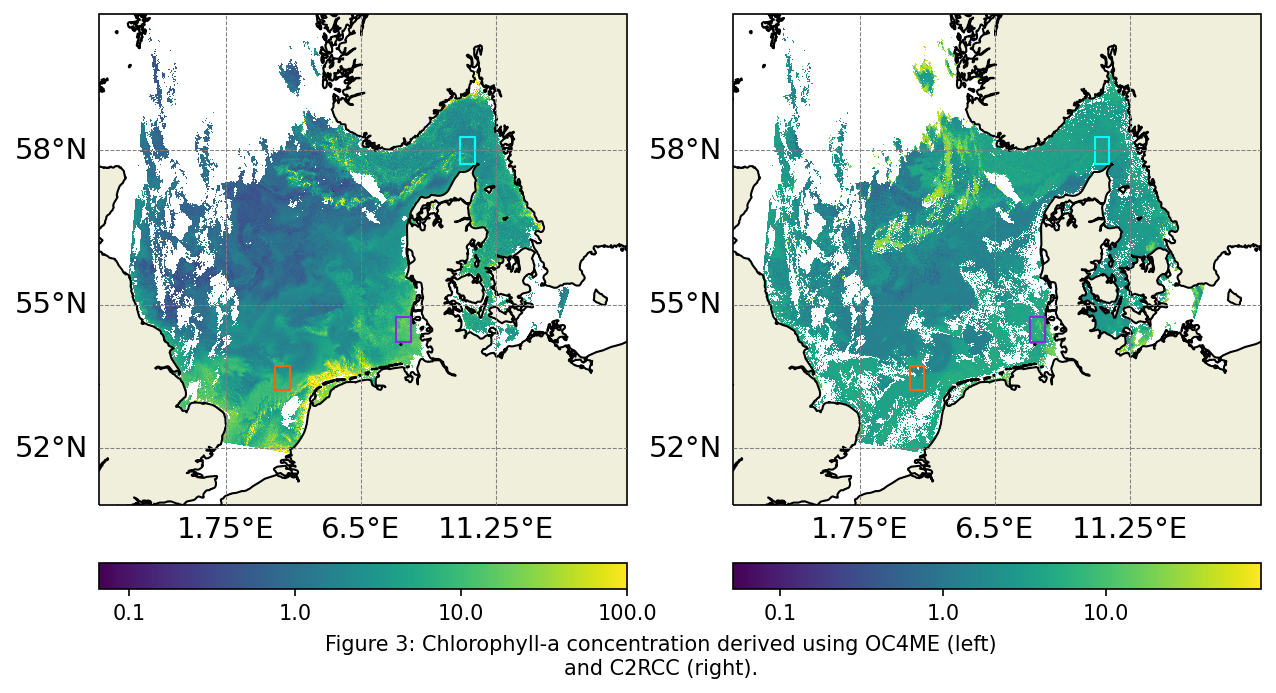

In [15]:
# initialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
gs = gridspec.GridSpec(1, 2)

# make axes and plot
for ii in range(2):
    if ii == 0: 
        var = CHL_OC4ME
    else:
        var = CHL_NN
        
    m = plt.subplot(gs[0,ii], projection=ccrs.Mercator())
    p1 = osf.plot_OLCI_scene(m, lon, lat, var)
    cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.1, ticks=[-2,-1,0,1,2])
    cbar.ax.set_xticklabels(10**np.asarray([-2,-1,0,1,2]).astype(float), fontsize=fsz)
    m.coastlines(resolution='10m', color='black', linewidth=0.25)
    m.add_feature(land_poly)
    # embellish with spectral boxes
    osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# add caption
fig1.text(0.5, 0.0, r'Figure 3: Chlorophyll-a concentration derived using OC4ME (left)'+'\n'\
          'and C2RCC (right).', ha='center', fontsize=fsz)
plt.show()

Next, you can also plot the TSM concentration, and compare this to the output from the application of the naive Bayes classifier you trained. 

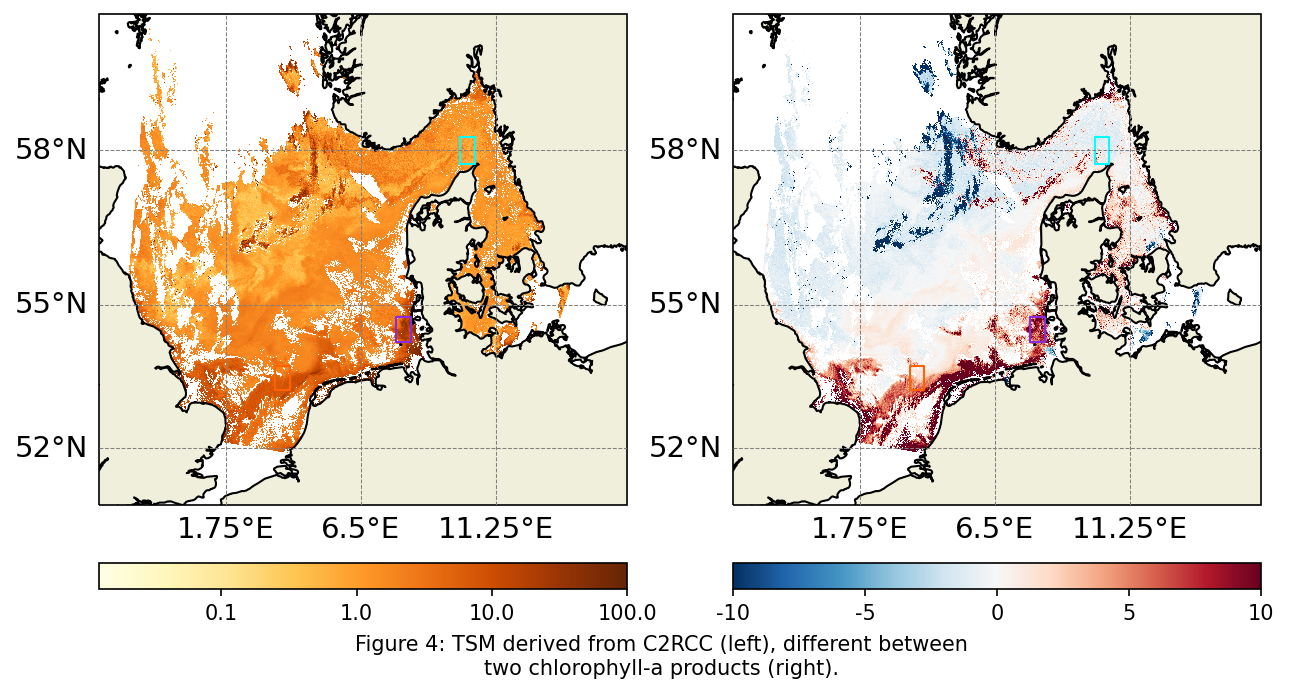

In [16]:
# intitialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
gs = gridspec.GridSpec(1, 2)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon, lat, TSM_NN, cmap=plt.cm.YlOrBr)
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.1, ticks=[-2,-1,0,1,2])
cbar.ax.set_xticklabels(10**np.asarray([-2,-1,0,1,2]).astype(float), fontsize=fsz)
m.coastlines(resolution='10m', color='black', linewidth=0.25)
m.add_feature(land_poly)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# make an axis and plot
m = plt.subplot(gs[0,1], projection=ccrs.Mercator())
anom = (10**(CHL_OC4ME) - 10**(CHL_NN))
anom[anom < -10] = -10 ; anom[anom > 10] = 10
p1 = osf.plot_OLCI_scene(m, lon, lat, anom, cmap=plt.cm.RdBu_r)
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.1, ticks=[-10,-5,0,5,10])
cbar.ax.set_xticklabels([-10,-5,0,5,10], fontsize=fsz)
m.coastlines(resolution='10m', color='black', linewidth=0.25)
m.add_feature(land_poly)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# add caption
fig1.text(0.5, 0.0, r'Figure 4: TSM derived from C2RCC (left), different between'+'\n'\
          'two chlorophyll-a products (right).', ha='center', fontsize=fsz)
plt.show()

*How do these different outputs solve our initial problem?*

In less complex waters (where phytoplankton are the dominant source of optical variability, and concentrations are relatively low), chlorophyll-a concentration can be readily estimated using empirical formulations based on the ratio's of blue to green light. In the level-2 OLCI products, one of these formulations (OC4ME) is used to generate a chlorophyll-a product (Figure 5, left). However, in complex waters, this approach becomes less accurate as the signal from chlorophyll-a and sediments, can overlap, meaning that high chlorophyll-a concentrations can be mis-attributed to high sediment concentrations. 

The C2RCC processor and it's associated products were to developed to address this problem as far as possible, and you can see how there are substantial differences in the resulting product (Figure 5, right - C2RCC chlorophyll-a concentration)  and that these typically occur where sediment concentrations are highest (Figure 6, left - C2RCC TSM concentration, Figure 6, right - difference between OC4ME and C2RCC chlorophyll-a products).

New figure showing bar chart of CHL and TSM for each box



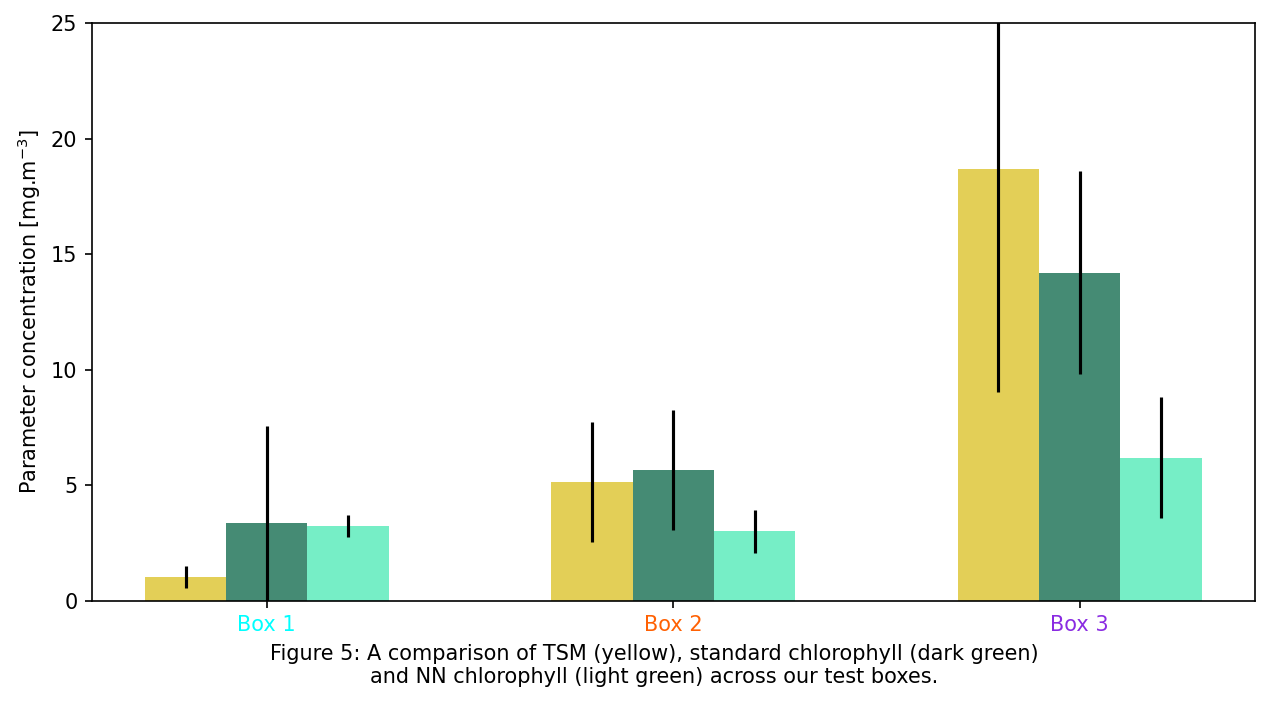

In [17]:
# intitialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

labels = ['Box 1','Box 2','Box 3']
plt.bar([0,1,2], TSM_mean, yerr=TSM_std, align='center', width=0.2, color='#E3CF57')
plt.bar([0.2,1.2,2.2], CHL_OC4ME_mean, yerr=CHL_OC4ME_std, align='center', width=0.2, color='#458B74')
plt.bar([0.4,1.4,2.4], CHL_NN_mean, yerr=CHL_NN_std, align='center', width=0.2, color='#76EEC6')

ax.set_ylabel('Parameter concentration [mg.m$^{-3}$]')
ax.set_xticks([0.2,1.2,2.2])
ax.set_xticklabels(labels)
plt.ylim([0,25])
for ii in range(len(spectral_box_extents)):
    ax.get_xticklabels()[ii].set_color(spectral_plot_cols[ii])
    
# add caption
fig1.text(0.5, 0.0, r'Figure 5: A comparison of TSM (yellow), standard chlorophyll (dark green)'+'\n'\
          'and NN chlorophyll (light green) across our test boxes.', ha='center', fontsize=fsz)
plt.show()

You may also be interested to compare the anomaly plot above with the output of our water type classifier from the previous exercise.

<img src='../../../img/4Fa_partition.png' align='centre' width='100%'></img>

<p style="text-align: center;">Figure 6: The outputs of our `naive bayesian classifier` for the same scene from our previous example.</p>

## 2 - Conclusions <a id='conclusions'></a>

Optically complex waters, such as those around our coasts, present challenges for ocean colour scientists. Isolating the concentration of specific in water components, such as chlorophyll-a, is difficult when the effects of sediment and dissolved organic matter are present. However, using recently developed machine learning approaches we are more able than ever to extract accurate information from these key regions. Community efforts, like the C2RCC processor shown here, put this power in users hands, allowing for the development of applications in regions where traditional approaches may fail.

For further examples of how Copernicus satellite data is used in water quality applications see [here](https://www.copernicus.eu/en/website-search?search_api_fulltext=water+quality).

<hr>

<img src='../../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
